# Model fitting notebook
---


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
import scipy.optimize
import random
from src.functions import * 

# Set some defaults
plt.rc("axes.spines", top=False, right=False)
sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

%config InlineBackend.figure_format = "retina"

---
## Load behavioral data


In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,motor_sd,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,0.323414,1.054281,NaN,NaN,2.507849,False,1.076975,6.542682,1.661801,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,0.309482,1.084872,-2.337005,-2.972700,-0.007217,False,1.076975,1.027300,1.661801,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,0.356222,1.100153,NaN,NaN,1.442153,False,1.076975,4.205676,1.661801,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,0.276952,1.339061,-0.427851,1.467717,1.105636,False,1.076975,3.467717,1.661801,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,0.241043,1.486548,NaN,NaN,1.247048,False,1.076975,3.777826,1.661801,False


---
## Helper functions

In [23]:
def calculate_adaptation(num_trials, n_per_miniblock, x):
    adaptation = np.zeros(num_trials)
    adaptation[1::n_per_miniblock] = x[2::n_per_miniblock] - x[0:-1:n_per_miniblock]
    
    return adaptation


def plot_individual(df, ege, ige, adaptation, color="k", title=None):
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":color}, ax=axs[0])
    axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptive response ($^\circ$)", 
               xlim=[-6.5, 6.5], xticks=np.arange(-4, 4.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
    axs[0].axhline(color="k", linewidth=0.5)

    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":color}, 
                scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2), xlim=[-6.5, 6.5], 
               xticks=np.arange(-4, 4.01, 2), xlabel="Motor noise ($^\circ$)", 
               ylabel="Adaptive response ($^\circ$)")
    axs[1].axhline(color="k", linewidth=0.5)
    
    sns.despine()
    fig.suptitle(title)
    plt.tight_layout()
    
    return fig

---
## Fit data using Maximum Likelihoood Estimation (MLE)

In [ ]:
%%time 
subj_num = []
model = []
theta = []
loglik = []
bic = []
delta_bic = []

# Fit models to data
for i in range(len(np.unique(df["SN"]))):
    subj = df.loc[df["SN"] == i + 1, :]
    
    # Extract important variables
    motor_sd = subj["motor_sd"].iloc[0]
    x_hand = subj["theta_maxradv_clean"].values
    rotation = subj["rotation"].values
    vis_fb = subj["fbi"].values

    # Define cost functions
    nll_pea = lambda x: negloglik(model="pea", sigma_int=x[0], B=x[1], bias=x[2], 
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_premo = lambda x: negloglik(model="premo", B=x[0], sigma_pred=x[1], 
                                         sigma_v=x[2], sigma_p=x[3], eta_p=x[4], bias=x[5], 
                                         sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, 
                                         x_hand=x_hand)
    nll_piece = lambda x: negloglik(model="piece", sigma_pert=x[0], sigma_comb=x[1], 
                                         bias = x[2], sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_rem = lambda x: negloglik(model="rem", sigma_comb=x[0], s=x[1], c=x[2], bias=x[3],
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    
    # Fit models: use different random initializations
    for k in range(10):
        # PEA model params: sigma_comb, B, bias
        bounds = ((0.01, 25), (0, 1), (-5, 5))
        tmp_pea = scipy.optimize.minimize(
            fun=nll_pea, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        )
            
        # PReMo model params: B, sigma_v, sigma_p, sigma_pred, eta_p, bias
        bounds = ((0, 1), (0.01, 25), (0.01, 25), (0.01, 25), (0, 1), (-5, 5))
        tmp_premo = scipy.optimize.minimize(
            fun=nll_premo,  
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1]),
                         np.random.uniform(low=bounds[4][0], high=bounds[4][1]),
                         np.random.uniform(low=bounds[5][0], high=bounds[5][1])])
        )
    
        # REM model params: sigma_comb, s, c, bias
        bounds = ((0.01, 25), (0, 10), (0, 10), (-5, 5))
        tmp_rem = scipy.optimize.minimize(
            fun=nll_rem, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1])])
        )
    
        # PIECE model params: sigma_pert, sigma_comb, bias
        bounds = ((0.01, 30), (0.01, 25), (-5, 5))
        tmp_piece = scipy.optimize.minimize(
            fun=nll_piece, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        )

        # Compare negative log-likelihoods; assign best results
        if k == 0:
            pea_results = tmp_pea
            premo_results = tmp_premo
            rem_results = tmp_rem
            piece_results = tmp_piece
        elif k != 0: 
            if tmp_pea.fun < pea_results.fun:
                pea_results = tmp_pea
            if tmp_premo.fun < premo_results.fun:
                premo_results = tmp_premo
            if tmp_rem.fun < rem_results.fun:
                rem_results = tmp_rem
            if tmp_piece.fun < piece_results.fun:
                piece_results = tmp_piece
            
        print(f"{i: } {pea_results.message}")
        print(f"{i: } {premo_results.message}")
        print(f"{i: } {rem_results.message}") 
        print(f"{i: } {piece_results.message}")
    
    # Fill in variables for "fits" data frame
    subj_num.extend([i + 1, i + 1, i + 1, i + 1])
    model.extend(["pea", "premo", "rem", "piece"])
    theta.extend([pea_results.x, premo_results.x, rem_results.x, 
                  piece_results.x])
    loglik.extend([pea_results.fun * -1, 
                   premo_results.fun * -1, rem_results.fun * -1, piece_results.fun * -1])
    bic.extend([calc_bic(pea_results.fun * -1, len(pea_results.x), len(subj)),
                calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj)),
                calc_bic(rem_results.fun * -1, len(rem_results.x), len(subj)),
                calc_bic(piece_results.fun * -1, len(piece_results.x), len(subj))])
    bic_ref = calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj))
    delta_bic.extend([bic[-4] - bic_ref, bic[-3] - bic_ref, bic[-2] - bic_ref, bic[-1] - bic_ref])

fits = pd.DataFrame({
    "subj_num":subj_num, 
    "model":model, 
    "theta":theta, 
    "loglik":loglik, 
    "bic":bic,
    "delta_bic":delta_bic
})

---
## Read and/or write parameters

In [8]:
# Save MLEs? 
write_data = False

# Read-in saved parameters?
read_data = True

# Helper function
def converter(input_str):
    return np.fromstring(input_str[1:-1], sep=' ')
    
# Write data to csv; look into preserving numpy dtype for "theta" column
if write_data:
    fits.to_csv("../results/params_mle_reducedmodels.csv", index=False)

# Need a function to convert string back to numpy array
if read_data:
    fits = pd.read_csv("../results/params_mle_reducedmodels.csv", converters={"theta":converter})

fits.head()

,subj_num,model,theta,loglik,bic,delta_bic
0,1,pea,"[9.34023228, 0.36206566, 1.29827665]",-2650.946357,5323.229696,-209.503440
1,1,premo,"[0.843862233, 16.7663819, 0.01, 25.0, 1.0, 1.0...",-2745.029585,5532.733135,0.000000
2,1,rem,"[14.2432723, 3.81197959, 9.99980445, 1.29836274]",-2650.973430,5330.396170,-202.336966
3,1,piece,"[5.95716432, 0.01, 1.01037002]",-2526.204156,5073.745295,-458.987840
4,2,pea,"[3.76251428, 0.49892211, 0.89640008]",-2854.631264,5730.599509,-186.281992


In [9]:
# Compute BIC deltas between models
idx_pea = fits["model"] == "pea"
idx_piece = fits["model"] == "piece"
idx_rem = fits["model"] == "rem"
idx_premo = fits["model"] == "premo"

fits["piece_v_pea"] = np.zeros(len(fits))
diff = fits.loc[idx_piece, "bic"].values - fits.loc[idx_pea, "bic"].values
fits.loc[idx_piece, "piece_v_pea"] = diff
fits

,subj_num,model,theta,loglik,bic,delta_bic,piece_v_pea
0,1,pea,"[9.34023228, 0.36206566, 1.29827665]",-2650.946357,5323.229696,-209.503440,0.000000
1,1,premo,"[0.843862233, 16.7663819, 0.01, 25.0, 1.0, 1.0...",-2745.029585,5532.733135,0.000000,0.000000
2,1,rem,"[14.2432723, 3.81197959, 9.99980445, 1.29836274]",-2650.973430,5330.396170,-202.336966,0.000000
3,1,piece,"[5.95716432, 0.01, 1.01037002]",-2526.204156,5073.745295,-458.987840,-249.484401
4,2,pea,"[3.76251428, 0.49892211, 0.89640008]",-2854.631264,5730.599509,-186.281992,0.000000
...,...,...,...,...,...,...,...
59,15,piece,"[5.68379772, 0.01, -0.00917741]",-2840.977019,5703.291021,-214.400677,-139.350106
60,16,pea,"[4.7871268, 0.20893975, 0.17375151]",-2706.225208,5433.787399,-51.680446,0.000000
61,16,premo,"[0.9260246, 1.24196536, 7.17215413, 5.54748381...",-2721.396940,5485.467845,0.000000,0.000000
62,16,rem,"[6.3403679, 1.10070837, 4.69398886, 0.17342872]",-2706.023335,5440.495979,-44.971865,0.000000


/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_54825/3833002909.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PEA", "REM", "PIECE"], xlabel="Model")


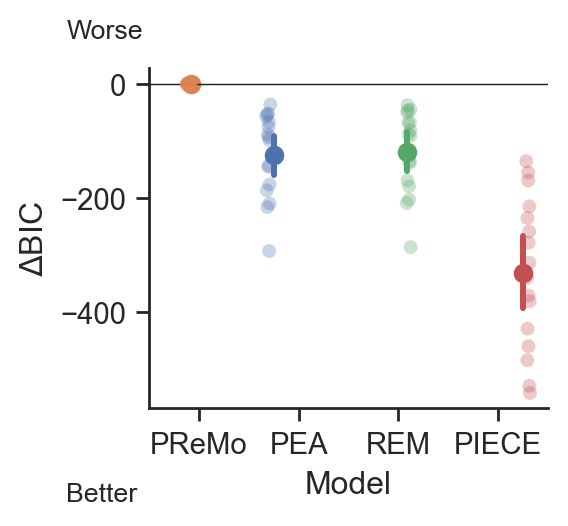

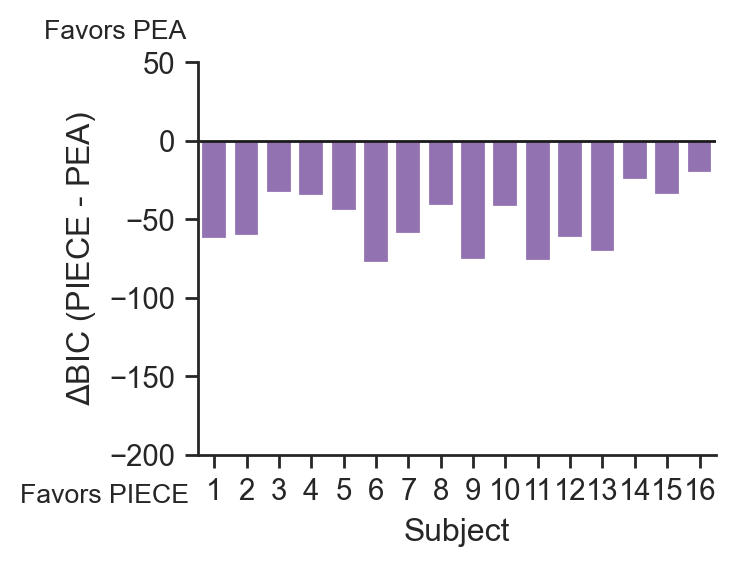

In [10]:
fig_bic, ax = plt.subplots(figsize=(3, 3))
sns.despine()
sns.stripplot(
    data=fits, x="model", y="delta_bic", dodge=True, alpha=0.3, hue="model", 
    legend=False, order=["premo", "pea", "rem", "piece"], ax=ax
)
sns.pointplot(
    data=fits, x="model", y="delta_bic", hue="model", dodge=0.5,
    order=["premo", "pea", "rem", "piece"], **{"linestyle":"none"},
    legend=False, ax=ax
)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PEA", "REM", "PIECE"], xlabel="Model")
ax.text(-1.33, 80, "Worse", fontsize="small")
ax.text(-1.33, -730, "Better", fontsize="small")
plt.tight_layout()

fig_comp, ax = plt.subplots(figsize=(4, 3))
sns.barplot(
    data=fits, x="subj_num", y="piece_v_pea", errorbar=None, color="tab:purple", 
    ax=ax
)
ax.axhline(c="k", linewidth=1)
ax.set(ylim=(-200, 50), xlabel="Subject", ylabel=r"$\Delta$BIC (PIECE - PEA)")
ax.text(-6, -230, "Favors PIECE", fontsize="small")
ax.text(-5.25, 65, "Favors PEA", fontsize="small")
sns.despine()
plt.tight_layout()

In [ ]:
# fig_bic.savefig("images/bic.png", dpi=300)
# fig_comp.savefig("images/piece-vs-pea.png", dpi=300)

---
# Plot Models using MLEs ($\hat{\Theta}_{\text{MLE}}$) 

In [37]:
# Choose a sample subject
sid = 6
sample_subj = df.loc[df["SN"] == sid, :].reset_index(drop=True)
sigma_motor = sample_subj.loc[0, "motor_sd"]

# Pull out best-fit params for chosen subject:
params_idx = fits["subj_num"] == sid 
params = fits.loc[params_idx, ["theta", "model"]].iloc[0:5, :].reset_index(drop=True)

# Pull out MLEs for each model
pea_mle = params.loc[params["model"] == "pea", "theta"].values[0]
premo_mle = params.loc[params["model"] == "premo", "theta"].values[0]
piece_mle = params.loc[params["model"] == "piece", "theta"].values[0]
rem_mle = params.loc[params["model"] == "rem", "theta"].values[0]

# Find perturbation trials
pert_indices = np.flatnonzero(sample_subj["perturbation"])

# Simulate with best-fit parameters
# PIECE model
_, xhat_piece = piece(
    piece_mle[0], 
    piece_mle[1], 
    piece_mle[2],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_piece = xhat_piece[pert_indices + 1] - xhat_piece[pert_indices - 1]

# PEA model
_, xhat_pea = pea(
    pea_mle[0], 
    pea_mle[1],
    pea_mle[2],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_pea = xhat_pea[pert_indices + 1] - xhat_pea[pert_indices - 1]

# PReMo 
_, xhat_premo = premo(
    premo_mle[0],
    premo_mle[1],
    premo_mle[2], 
    premo_mle[3],
    premo_mle[4],
    premo_mle[5],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_premo = xhat_premo[pert_indices + 1] - xhat_premo[pert_indices - 1]

# REM
_, xhat_rem = rem(
    rem_mle[0],
    rem_mle[1], 
    rem_mle[2],
    rem_mle[3],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_rem = xhat_rem[pert_indices + 1] - xhat_rem[pert_indices - 1]

# Create data frame with all perturbation trials
df1 = pd.DataFrame({
    "rotation":sample_subj.loc[pert_indices, "rotation"],
    "xhat_piece":xhat_piece[pert_indices],
    "adapt_piece":adapt_piece,
    "xhat_pea":xhat_pea[pert_indices],
    "adapt_pea":adapt_pea,
    "xhat_premo":xhat_premo[pert_indices],
    "adapt_premo":adapt_premo,
    "xhat_rem":xhat_rem[pert_indices], 
    "adapt_rem":adapt_rem
})


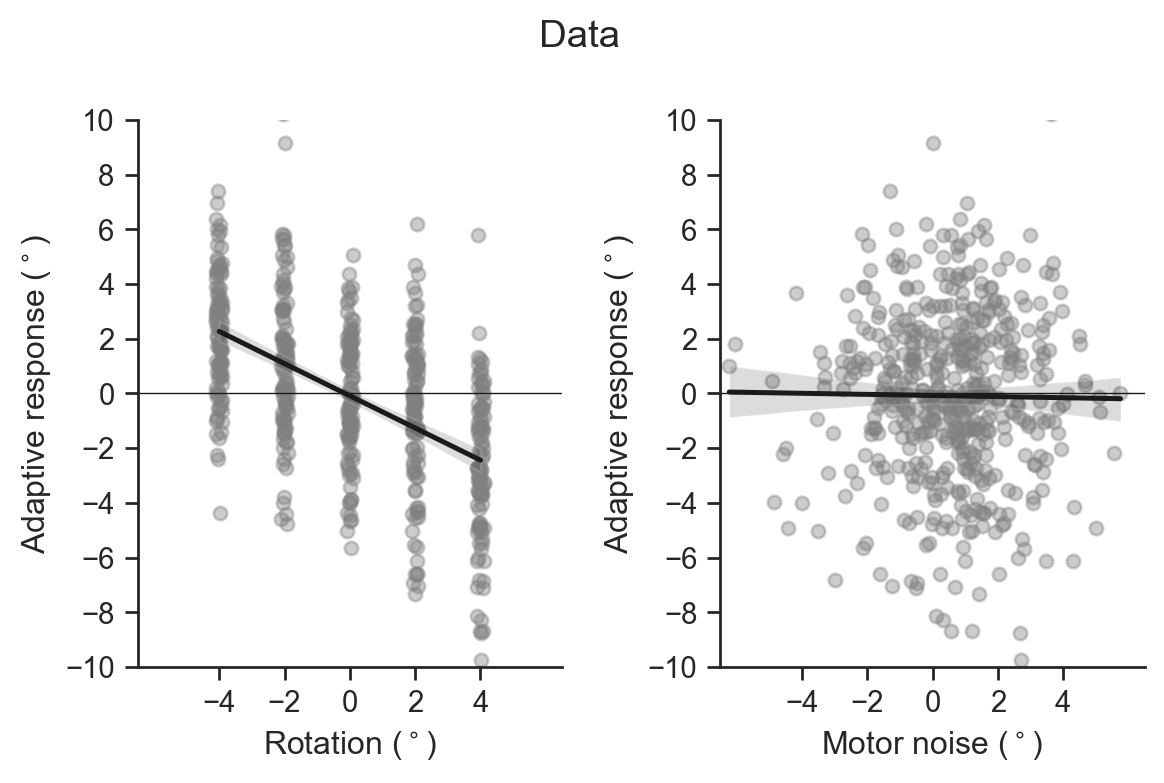

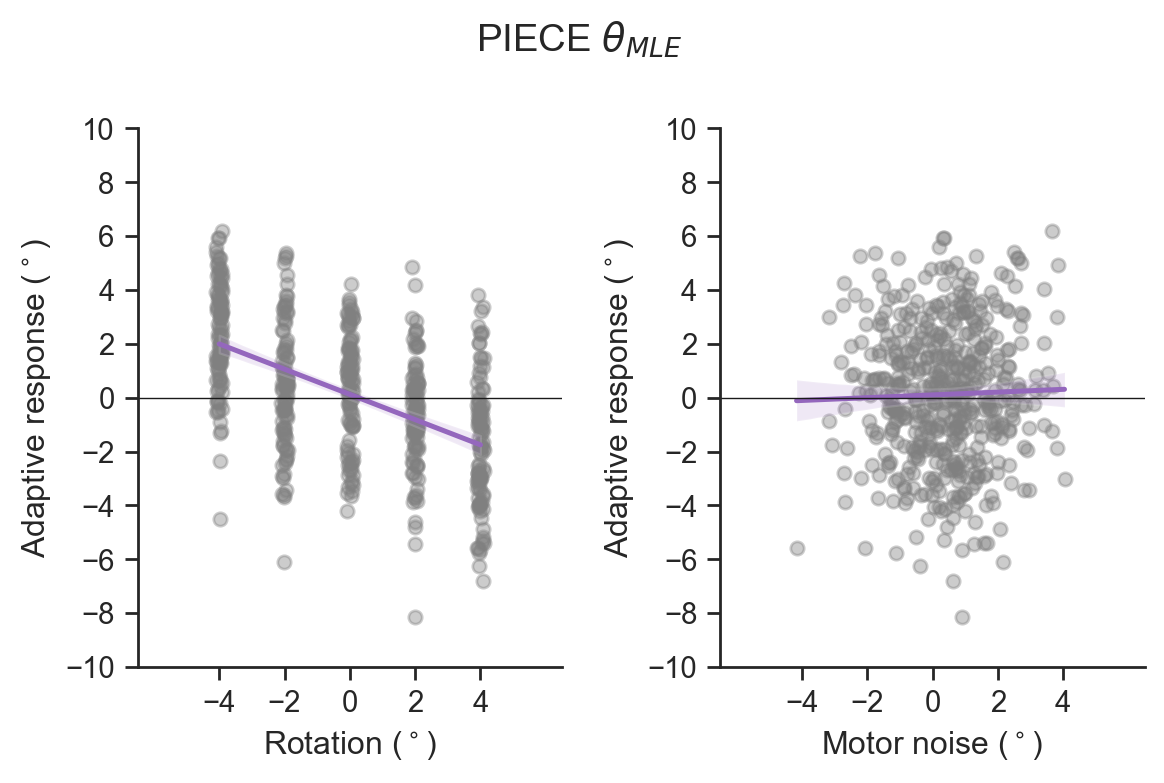

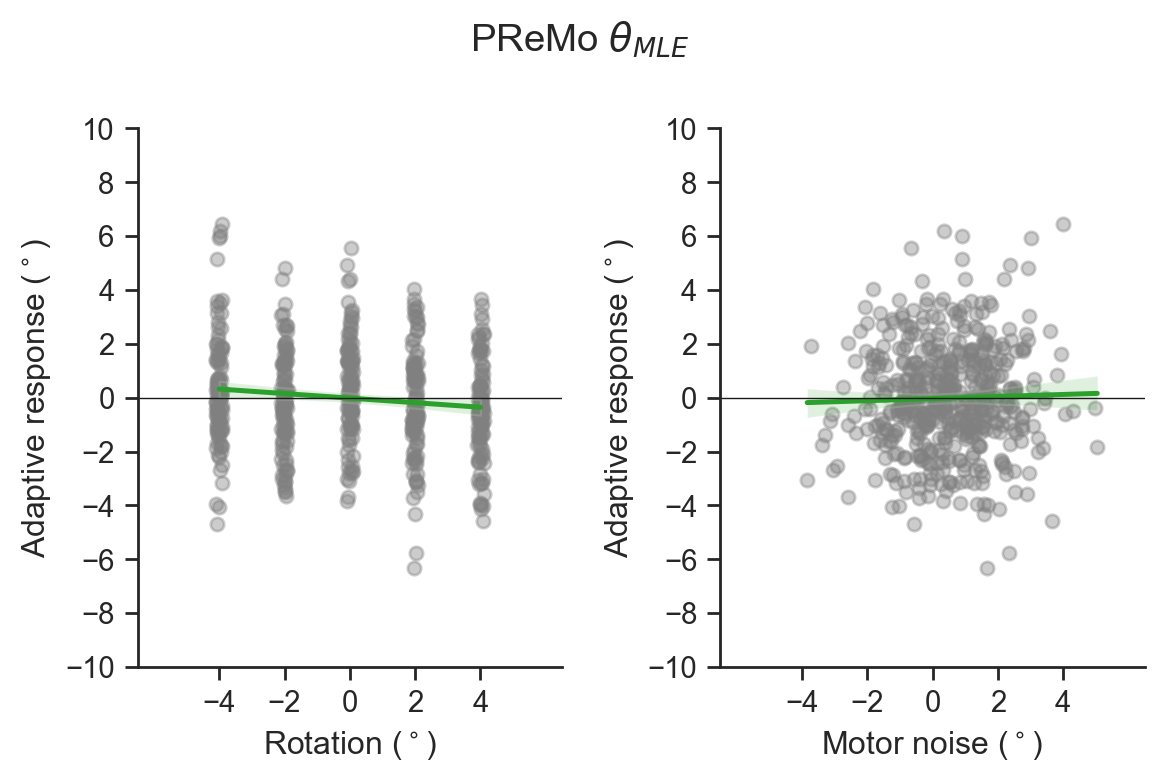

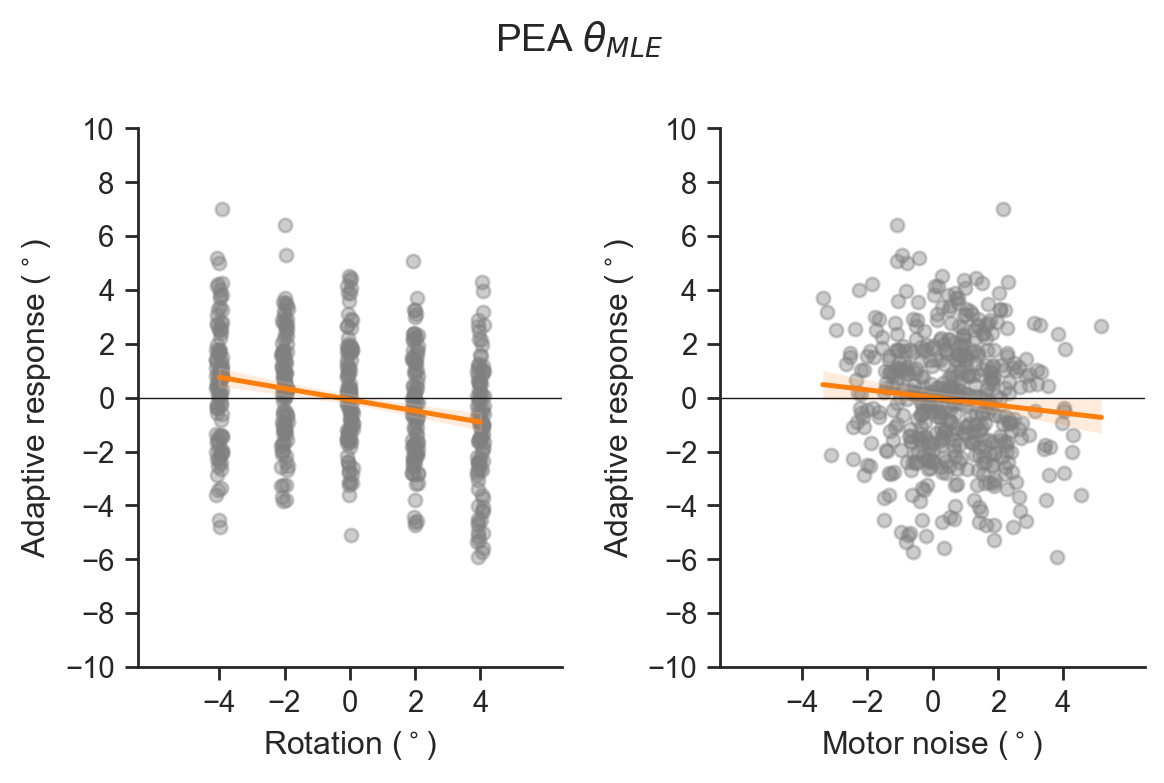

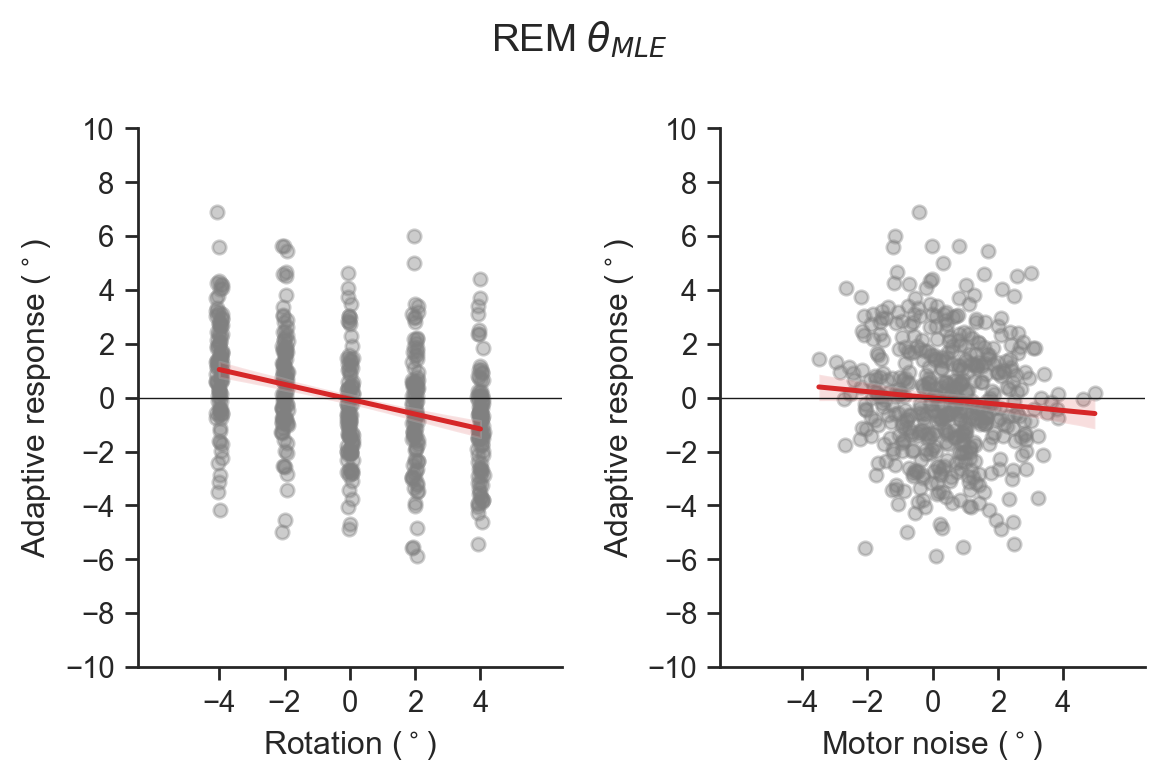

In [38]:
# Assign colors to models
premo_color = "tab:green"
piece_color = "tab:purple"
pea_color = "tab:orange"
rem_color = "tab:red"

# Plot best-fits
fig1 = plot_individual(sample_subj, "rotation", "theta_maxradv_clean", "adaptation", title="Data")
fig2 = plot_individual(df1, "rotation", "xhat_piece", "adapt_piece", piece_color, r"PIECE $\theta_{MLE}$")
fig3 = plot_individual(df1, "rotation", "xhat_premo", "adapt_premo", premo_color, r"PReMo $\theta_{MLE}$")
fig4 = plot_individual(df1, "rotation", "xhat_pea", "adapt_pea", pea_color, r"PEA $\theta_{MLE}$")
fig5 = plot_individual(df1, "rotation", "xhat_rem", "adapt_rem", rem_color, r"REM $\theta_{MLE}$")


In [ ]:
# fig1.savefig("images/s6-real-color.png", dpi=300)
# fig2.savefig("images/s6-piece-color.png", dpi=300)
# fig3.savefig("images/s6-premo-color.png", dpi=300)
# fig4.savefig("images/s6-pea-color.png", dpi=300)
# fig5.savefig("images/s6-rem-color.png", dpi=300)